# Truora

# 1 Author

**Student Name**:  Zheyun Zhao

**Student ID**:  221170559



# 2 Problem formulation

Describe the machine learning problem that you want to solve and explain what's interesting about it.

# 3 Methodology

Describe your methodology. Specifically, describe your training task and validation task, and how model performance is defined (i.e. accuracy, confusion matrix, etc). Any other tasks that might help you build your model should also be described here.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from typing import List, Tuple, Dict, Any, Optional
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)

In [2]:
class Config:
    """
    Configuration class for setting up dataset paths, labels, model parameters, and training configurations.

    Attributes:
        train_dataset (str): Path to the training dataset.
        validation_dataset (str): Path to the validation dataset.
        test_dataset (str): Path to the test dataset.
        labels (List[str]): List of label names.
        model_path (str): Directory path to save and load models.
        epochs (int): Number of training epochs.
        batch_size (int): Size of each training batch.
    """

    train_dataset: str
    validation_dataset: str 
    test_dataset: str
    labels: List[str]
    model_path: str
    epochs: int
    batch_size: int

    def __init__(
        self,
        train_dataset: str = "../datasets/train.npz",
        validation_dataset: str = "../datasets/validation.npz", 
        test_dataset: str = "../datasets/test.npz",
        labels: List[str] = ["True Story", "Deceptive Story"],
        model_path: str = "../models/",
        epochs: int = 100,
        batch_size: int = 10,
    ):
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.test_dataset = test_dataset
        self.labels = labels
        self.model_path = model_path
        self.epochs = epochs
        self.batch_size = batch_size

# 4 Implemented ML prediction pipelines

Describe the ML prediction pipelines that you will explore. Clearly identify their input and output, stages and format of the intermediate data structures moving from one stage to the next. It's up to you to decide which stages to include in your pipeline. After providing an overview, describe in more detail each one of the stages that you have included in their corresponding subsections (i.e. 4.1 Transformation stage, 4.2 Model stage, 4.3 Ensemble stage).

## 4.1 Transformation stage

Describe any transformations, such as feature extraction. Identify input and output. Explain why you have chosen this transformation stage.

In [3]:
import librosa

class DataTransformer:
  """
  Handles data loading and feature extraction for audio datasets.

  Attributes:
      config (Config): Configuration object containing dataset paths and parameters.
  """
  def __init__(self, config: Config) -> None:
    """
    Initializes the DataTransformer with the given configuration.

    Args:
        config (Config): Configuration object.
    """
    self.config: Config = config

  @staticmethod
  def load_data_from_npz(file_path: str) -> np.ndarray:
    """
    Loads data from a .npz file.

    Args:
        file_path (str): Path to the .npz file.

    Returns:
        np.ndarray: Loaded data.
    """
    data: np.ndarray = np.load(file_path)
    return data

  def get_datasets(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Retrieves training, validation, and test datasets.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            Tuple containing features and labels for training, validation, and test sets.
    """
    train_data: np.ndarray = self.load_data_from_npz(self.config.train_dataset)
    validation_data: np.ndarray = self.load_data_from_npz(self.config.validation_dataset)
    test_data: np.ndarray = self.load_data_from_npz(self.config.test_dataset)
    return train_data["features"], train_data["labels"], validation_data["features"], validation_data["labels"], test_data["features"], test_data["labels"]
      
  @staticmethod
  def extract_features(
      file_path: str,
      sr: int = 16000,
      n_mels: int = 128,
      duration: int = 240,
  ) -> np.ndarray:
    """
    Extracts audio features from a given file, including Mel-Spectrogram, MFCC, Chroma, ZCR, energy, duration,
    spectral centroid, spectral rolloff, and spectral flux. All features are concatenated into a single matrix
    with fixed length processing.

    Args:
        file_path (str): Path to the audio file.
        sr (int, optional): Sampling rate. Defaults to 16000.
        n_mels (int, optional): Number of Mel bands. Defaults to 128.
        duration (int, optional): Duration of the audio in seconds. Defaults to 240.

    Returns:
        np.ndarray: Extracted and concatenated features.
    """
    audio: np.ndarray
    sr: int
    audio, sr = librosa.load(file_path, sr=sr)

    mel_spectrogram: np.ndarray = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels
    )
    log_mel_spectrogram: np.ndarray = librosa.power_to_db(mel_spectrogram)

    mfcc: np.ndarray = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

    chroma: np.ndarray = librosa.feature.chroma_stft(y=audio, sr=sr)

    zero_crossing_rate: np.ndarray = librosa.feature.zero_crossing_rate(y=audio)
    short_term_energy: float = np.sum(audio ** 2) / len(audio)
    duration_feature: float = len(audio) / sr

    spectral_centroid: np.ndarray = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_rolloff: np.ndarray = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85)
    spectral_flux: np.ndarray = librosa.onset.onset_strength(y=audio, sr=sr)

    features: np.ndarray = np.vstack([
        log_mel_spectrogram,
        mfcc,
        chroma,
        zero_crossing_rate,
        spectral_centroid,
        spectral_rolloff,
        spectral_flux,
    ])

    target_length: int = int(sr * duration / 512)
    if features.shape[1] < target_length:
      padding: np.ndarray = np.zeros((features.shape[0], target_length - features.shape[1]))
      features = np.concatenate([features, padding], axis=1)
    else:
      features = features[:, :target_length]

    additional_features = np.array([short_term_energy, duration_feature])
    additional_features = np.repeat(additional_features[:, np.newaxis], features.shape[1], axis=1)

    features = np.concatenate([features, additional_features], axis=0)

    return features

## 4.2 Model stage

Describe the ML model(s) that you will build. Explain why you have chosen them.

In [4]:
from abc import ABC, abstractmethod


class BaseModel(ABC):
    """
    Abstract base class for models, supporting lifecycle management and core functionality.
    """

    def __init__(self) -> None:
        """
        Initializes the BaseModel with default settings.
        """
        self.use: bool = True
        self.model: Optional[Any] = None

    @abstractmethod
    def build(self, **kwargs: Any) -> None:
        """
        Build the model architecture.

        Args:
            **kwargs: Additional keyword arguments for building the model.
        """
        pass

    @abstractmethod
    def train(self, X_train: Any, y_train: Any, **kwargs: Any) -> None:
        """
        Train the model on the provided data.

        Args:
            X_train (Any): Training features.
            y_train (Any): Training labels.
            **kwargs: Additional keyword arguments for training.
        """
        pass

    @abstractmethod
    def predict(self, X_test: Any) -> Any:
        """
        Generate predictions for the provided test data.

        Args:
            X_test (Any): Test features.

        Returns:
            Any: Predictions.
        """
        pass

    @abstractmethod
    def save(self, path: str) -> None:
        """
        Save the model to the specified path.

        Args:
            path (str): File path to save the model.
        """
        pass

    @abstractmethod
    def load(self, path: str) -> None:
        """
        Load the model from the specified path.

        Args:
            path (str): File path to load the model from.
        """
        pass

    def get(self) -> Optional[Any]:
        """
        Retrieve the model instance if enabled.

        Returns:
            Optional[Any]: The model instance or None if disabled.
        """
        return self.model if self.use else None

    def enable(self) -> None:
        """
        Enable the model for use.
        """
        self.use = True

    def disable(self) -> None:
        """
        Disable the model from being used.
        """
        self.use = False

In [5]:
import os
from keras import layers, models, callbacks

def show_history(history: callbacks.History) -> None:
    """
    Plots the training and validation accuracy and loss over epochs.

    Args:
        history: History object returned by model.fit().
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

class NNModel(BaseModel):
    """
    Neural Network model using CNN-LSTM architecture with Attention mechanism.
    """
    def __init__(self) -> None:
        """
        Initializes the NNModel.
        """
        super().__init__()

    def build(self, input_shape: Tuple[int, int, int]) -> models.Model:
        """
        Builds the CNN-LSTM model architecture.

        Args:
            input_shape (Tuple[int, int, int]): Shape of the input data.

        Returns:
            models.Model: Compiled Keras model.
        """
        model_input = layers.Input(shape=input_shape)

        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(model_input)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)

        x = layers.Reshape((1, 128))(x)  # (batch_size, sequence_length=1, feature_dim=128)
        attention_output = layers.Attention()([x, x])  # Self-Attention

        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(attention_output)
        x = layers.Bidirectional(layers.LSTM(64))(x)

        x = layers.Dense(64, activation="relu", kernel_regularizer="l2")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        output = layers.Dense(1, activation="sigmoid")(x)

        model = models.Model(inputs=model_input, outputs=output)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        self.model = model
        return self.model

    def train(self, X_train: Any, y_train: Any, x_val: Any, y_val: Any, model_path: str, epochs: int = 10, batch_size: int = 32) -> models.Model:
        """
        Trains the Neural Network model.

        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.
            x_val (np.ndarray): Validation features.
            y_val (np.ndarray): Validation labels.
            model_path (str): Path to save the best model.
            epochs (int, optional): Number of training epochs. Defaults to 10.
            batch_size (int, optional): Batch size for training. Defaults to 32.

        Returns:
            models.Model: Trained Keras model.
        """
        print(f"Training Neural Network ...")

        lr_scheduler = callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )
        early_stopping = callbacks.EarlyStopping(monitor="loss", patience=100)
        model_checkpoint = callbacks.ModelCheckpoint(
            filepath=os.path.join(model_path, f"nn_model.keras"),
            monitor="val_accuracy",
            save_best_only=True
        )
        callbacks_list = [lr_scheduler, early_stopping, model_checkpoint]

        history = self.model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            callbacks=callbacks_list
        )
        show_history(history)

        return self.model

    def predict(self, X_test: Any) -> Any:
        """
        Generates predictions for the test data.

        Args:
            X_test (np.ndarray): Test features.

        Returns:
            np.ndarray: Flattened prediction probabilities.
        """
        return self.model.predict(X_test).flatten()

    def save(self, path: str) -> None:
        """
        Saves the model to the specified path.

        Args:
            path (str): Path to save the model.
        """
        self.model.save(path)

    def load(self, path: str) -> models.Model:
        """
        Loads the model from the specified path.

        Args:
            path (str): Path to load the model from.

        Returns:
            models.Model: Loaded Keras model.
        """
        self.model = models.load_model(path)
        return self.model

In [6]:
from sklearn.ensemble import RandomForestClassifier

class RFModel(BaseModel):
    """
    Random Forest Classifier model.
    """
    def __init__(self) -> None:
        """
        Initializes the RFModel.
        """
        super().__init__()

    def build(self, n_estimators: int = 100, random_state: int = 42) -> RandomForestClassifier:
        """
        Builds the Random Forest model.

        Args:
            n_estimators (int, optional): Number of trees in the forest. Defaults to 100.
            random_state (int, optional): Random state for reproducibility. Defaults to 42.

        Returns:
            RandomForestClassifier: Initialized Random Forest model.
        """
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        return self.model

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> RandomForestClassifier:
        """
        Trains the Random Forest model.

        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.

        Returns:
            RandomForestClassifier: Trained Random Forest model.
        """
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Generates prediction probabilities for the test data.

        Args:
            X_test (np.ndarray): Test features.

        Returns:
            np.ndarray: Probability of the positive class.
        """
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict_proba(X_test_2d)[:, 1]

    def save(self, path: str) -> None:
        """
        Saves the Random Forest model to the specified path.

        Args:
            path (str): Path to save the model.
        """
        joblib.dump(self.model, path)

    def load(self, path: str) -> RandomForestClassifier:
        """
        Loads the Random Forest model from the specified path.

        Args:
            path (str): Path to load the model from.

        Returns:
            RandomForestClassifier: Loaded Random Forest model.
        """
        self.model = joblib.load(path)
        return self.model

In [7]:
from sklearn.neighbors import KNeighborsClassifier

class KNNModel(BaseModel):
    """
    K-Nearest Neighbors Classifier model.
    """
    def __init__(self) -> None:
        """
        Initializes the KNNModel.
        """
        super().__init__()

    def build(self, n_neighbors: int = 5) -> KNeighborsClassifier:
        """
        Builds the KNN model.

        Args:
            n_neighbors (int, optional): Number of neighbors to use. Defaults to 5.

        Returns:
            KNeighborsClassifier: Initialized KNN model.
        """
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors)
        return self.model

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> KNeighborsClassifier:
        """
        Trains the KNN model.

        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.

        Returns:
            KNeighborsClassifier: Trained KNN model.
        """
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Generates predictions for the test data.

        Args:
            X_test (np.ndarray): Test features.

        Returns:
            np.ndarray: Predicted class labels.
        """
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict(X_test_2d)

    def save(self, path: str) -> None:
        """
        Saves the KNN model to the specified path.

        Args:
            path (str): Path to save the model.
        """
        joblib.dump(self.model, path)

    def load(self, path: str) -> KNeighborsClassifier:
        """
        Loads the KNN model from the specified path.

        Args:
            path (str): Path to load the model from.

        Returns:
            KNeighborsClassifier: Loaded KNN model.
        """
        self.model = joblib.load(path)
        return self.model

In [8]:
from sklearn.linear_model import LogisticRegression

class LRModel(BaseModel):
    """
    Logistic Regression Classifier model.
    """

    def __init__(self) -> None:
        """
        Initializes the LRModel.
        """
        super().__init__()

    def build(self, C: float = 1.0, random_state: int = 42, max_iter: int = 100) -> LogisticRegression:
        """
        Builds the Logistic Regression model.

        Args:
            C (float, optional): Inverse of regularization strength. Defaults to 1.0.
            random_state (int, optional): Random state for reproducibility. Defaults to 42.
            max_iter (int, optional): Maximum number of iterations. Defaults to 100.

        Returns:
            LogisticRegression: Initialized Logistic Regression model.
        """
        self.model = LogisticRegression(C=C, random_state=random_state, max_iter=max_iter)
        return self.model

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> LogisticRegression:
        """
        Trains the Logistic Regression model.

        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.

        Returns:
            LogisticRegression: Trained Logistic Regression model.
        """
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Generates prediction probabilities for the test data.

        Args:
            X_test (np.ndarray): Test features.

        Returns:
            np.ndarray: Probability of the positive class.
        """
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict_proba(X_test_2d)[:, 1]

    def save(self, path: str) -> None:
        """
        Saves the Logistic Regression model to the specified path.

        Args:
            path (str): Path to save the model.
        """
        joblib.dump(self.model, path)

    def load(self, path: str) -> LogisticRegression:
        """
        Loads the Logistic Regression model from the specified path.

        Args:
            path (str): Path to load the model from.

        Returns:
            LogisticRegression: Loaded Logistic Regression model.
        """
        self.model = joblib.load(path)
        return self.model

In [9]:
from sklearn.svm import SVC

class SVM(BaseModel):
    """
    Support Vector Machine Classifier model.
    """

    def __init__(self) -> None:
        """
        Initializes the SVM model.
        """
        super().__init__()

    def build(self, C: float = 1.0, kernel: str = 'rbf') -> SVC:
        """
        Builds the SVM model.

        Args:
            C (float, optional): Regularization parameter. Defaults to 1.0.
            kernel (str, optional): Kernel type to be used in the algorithm. Defaults to 'rbf'.

        Returns:
            SVC: Initialized SVM model.
        """
        self.model = SVC(C=C, kernel=kernel, probability=True)
        return self.model

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> SVC:
        """
        Trains the SVM model.

        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.

        Returns:
            SVC: Trained SVM model.
        """
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train_2d, y_train)
        return self.model

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """
        Generates predictions for the test data.

        Args:
            X_test (np.ndarray): Test features.

        Returns:
            np.ndarray: Predicted class labels.
        """
        X_test_2d = X_test.reshape(X_test.shape[0], -1)
        return self.model.predict(X_test_2d)

    def save(self, path: str) -> None:
        """
        Saves the SVM model to the specified path.

        Args:
            path (str): Path to save the model.
        """
        joblib.dump(self.model, path)

    def load(self, path: str) -> SVC:
        """
        Loads the SVM model from the specified path.

        Args:
            path (str): Path to load the model from.

        Returns:
            SVC: Loaded SVM model.
        """
        self.model = joblib.load(path)
        return self.model

In [10]:
class ModelBuilder:
    """
    Responsible for constructing and returning the required models.
    Currently includes CNN-LSTM model (with Attention) and various traditional machine learning models.
    """

    @staticmethod
    def build_nn_model(input_shape: Tuple[int, int, int]) -> NNModel:
        """
        Builds the Neural Network model.

        Args:
            input_shape (Tuple[int, int, int]): Shape of the input data.

        Returns:
            NNModel: Built Neural Network model.
        """
        nn_model: NNModel = NNModel()
        nn_model.build(input_shape)
        return nn_model

    @staticmethod
    def build_rf_model(random_state: int = 42, n_estimators: int = 100) -> RFModel:
        """
        Builds the Random Forest model.

        Args:
            random_state (int, optional): Random state for reproducibility. Defaults to 42.
            n_estimators (int, optional): Number of trees in the forest. Defaults to 100.

        Returns:
            RFModel: Built Random Forest model.
        """
        rf_model: RFModel = RFModel()
        rf_model.build(random_state=random_state, n_estimators=n_estimators)
        return rf_model

    @staticmethod
    def build_knn_model(n_neighbors: int = 3) -> KNNModel:
        """
        Builds the K-Nearest Neighbors model.

        Args:
            n_neighbors (int, optional): Number of neighbors to use. Defaults to 3.

        Returns:
            KNNModel: Built KNN model.
        """
        knn_model: KNNModel = KNNModel()
        knn_model.build(n_neighbors=n_neighbors)
        return knn_model

    @staticmethod
    def build_logistic_regression_model(C: float = 1, random_state: int = 42, max_iter: int = 100) -> LRModel:
        """
        Builds the Logistic Regression model.

        Args:
            C (float, optional): Inverse of regularization strength. Defaults to 1.
            random_state (int, optional): Random state for reproducibility. Defaults to 42.
            max_iter (int, optional): Maximum number of iterations. Defaults to 100.

        Returns:
            LRModel: Built Logistic Regression model.
        """
        lr_model: LRModel = LRModel()
        lr_model.build(C=C, random_state=random_state, max_iter=max_iter)
        return lr_model

    @staticmethod
    def build_svm_model(C: float = 1.0, kernel: str = "rbf") -> SVM:
        """
        Builds the Support Vector Machine model.

        Args:
            C (float, optional): Regularization parameter. Defaults to 1.0.
            kernel (str, optional): Kernel type to be used in the algorithm. Defaults to 'rbf'.

        Returns:
            SVM: Built SVM model.
        """
        svm_model: SVM = SVM()
        svm_model.build(C=C, kernel=kernel)
        return svm_model

## 4.3 Ensemble stage

Describe any ensemble approach you might have included. Explain why you have chosen them.

In [11]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, labels: List[str]) -> None:
    """
    Plots the confusion matrix using seaborn heatmap.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        labels (List[str]): List of label names.
    """
    import matplotlib.pyplot as plt
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cm_rearranged: np.ndarray = np.array([[tp, fp],
                                          [fn, tn]])
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_rearranged,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.xlabel("Actual class", fontsize=12)
    plt.ylabel("Predicted class", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.gca().xaxis.set_label_position("top")
    plt.gca().xaxis.tick_top()
    plt.show()


def plot_roc_curve(y_true: np.ndarray, y_pred_prob: np.ndarray) -> None:
    """
    Plots the Receiver Operating Characteristic (ROC) curve.

    Args:
        y_true (np.ndarray): True labels.
        y_pred_prob (np.ndarray): Predicted probabilities for the positive class.
    """
    import matplotlib.pyplot as plt
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc: float = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.xlabel("1 - Specificity (FPR)")
    plt.ylabel("Sensitivity (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

In [12]:
class Predictor:
    """
    Used for model prediction and output results. Includes methods for ensemble predictions.
    """
    @staticmethod
    def ensemble_predict(
        X_test: np.ndarray,
        **kwargs: dict[str, Any]
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Performs ensemble prediction by averaging the probabilities from multiple models.

        Args:
            X_test (np.ndarray): Test features.
            **kwargs: Models to be used for prediction, passed as keyword arguments.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Final predicted classes and their probabilities.
        """
        model_list: List[str] = ["nn_model", "rf_model", "knn_model", "lr_model", "svm_model"]
        models: Dict[str, Any] = {k: v for k, v in kwargs.items() if k in model_list}

        if not any(models.values()):
            raise ValueError("At least one model is required!")

        predictions: List[np.ndarray] = []

        for model_name, model in models.items():
            if model is None or not model.use:
                continue
            preds: np.ndarray = model.predict(X_test)
            predictions.append(preds)
            print(f"{model_name} Predictions: {preds}")

        num_sources: int = len(predictions)
        weights: Optional[List[float]] = kwargs.get("weights")
        if weights is None:
            weights = [1.0 / num_sources] * num_sources
        elif len(weights) != num_sources:
            raise ValueError("The number of weights must match the number of models used for prediction!")

        final_pred_prob: np.ndarray = np.average(predictions, axis=0, weights=weights)
        final_pred: np.ndarray = (final_pred_prob > 0.5).astype(int)

        return final_pred, final_pred_prob

In [13]:
class Evaluator:
    """
    Evaluates models, including metric calculations, confusion matrix, and ROC curve plotting.
    """
    @staticmethod
    def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> None:
        """
        Prints classification report, confusion matrix, and various metrics.

        Args:
            y_true (np.ndarray): True labels.
            y_pred (np.ndarray): Predicted labels.
        """
        report: str = classification_report(y_true, y_pred)
        print("Classification Report:\n", report)

        cm: np.ndarray = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", cm)

        TN, FP, FN, TP = cm.ravel()

        sensitivity: float = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity: float = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision: float = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1_score: float = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        print(f"Sensitivity: {sensitivity:.2f}")
        print(f"Specificity: {specificity:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"F1 Score: {f1_score:.2f}")

        accuracy: float = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {accuracy:.2f}")

    def evaluate_ensemble_model(
        self,
        *,
        X_test: np.ndarray,
        y_true: np.ndarray,
        labels: List[str],
        **kwargs: dict[str, Any]
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Evaluates the ensemble model by performing ensemble predictions and plotting evaluation metrics.

        Args:
            X_test (np.ndarray): Test features.
            y_true (np.ndarray): True labels.
            labels (List[str]): List of label names.
            **kwargs: Models to be used for prediction, passed as keyword arguments.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Final predicted classes and their probabilities.
        """
        final_pred, final_pred_prob = Predictor.ensemble_predict(X_test=X_test, **kwargs)
        print("\nEnsemble Model Evaluation:")
        self.evaluate_model(y_true, final_pred)
        plot_confusion_matrix(y_true, final_pred, labels=labels)
        plot_roc_curve(y_true, final_pred_prob)
        return final_pred, final_pred_prob

# 5 Dataset

Describe the datasets that you will create to build and evaluate your models. Your datasets need to be based on our MLEnd Deception Dataset. After describing the datasets, build them here. You can explore and visualise the datasets here as well. 

If you are building separate training and validatio datasets, do it here. Explain clearly how you are building such datasets, how you are ensuring that they serve their purpose (i.e. they are independent and consist of IID samples) and any limitations you might think of. It is always important to identify any limitations as early as possible. The scope and validity of your conclusions will depend on your ability to understand the limitations of your approach.

If you are exploring different datasets, create different subsections for each dataset and give them a name (e.g. 5.1 Dataset A, 5.2 Dataset B, 5.3 Dataset 5.3) .



In [14]:
import soundfile as sf

CONFIG = {
    "dataset_path": "../datasets/",
    "story_path": "../datasets/CBU0521DD_stories/",
    "label_path": "../datasets/CBU0521DD_stories_attributes.csv",
    "augmented_story_path": "../datasets/CBU0521DD_stories/_augmented/",
    "augmented_label_path": "../datasets/CBU0521DD_stories_attributes_augmented.csv",
}

In [15]:
# Data augmentation methods: time stretch, pitch shift, add noise, change volume
def time_stretch(y: np.ndarray, rate: float = 1.2) -> np.ndarray:
    """
    Applies time stretching to the audio signal.

    Args:
        y (np.ndarray): Audio signal.
        rate (float, optional): Stretching rate. Defaults to 1.2.

    Returns:
        np.ndarray: Time-stretched audio signal.
    """
    return librosa.effects.time_stretch(y, rate=rate)

def pitch_shift(y: np.ndarray, sr: int, n_steps: int = 4) -> np.ndarray:
    """
    Applies pitch shifting to the audio signal.

    Args:
        y (np.ndarray): Audio signal.
        sr (int): Sampling rate.
        n_steps (int, optional): Number of steps to shift. Defaults to 4.

    Returns:
        np.ndarray: Pitch-shifted audio signal.
    """
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def add_noise(y: np.ndarray, noise_level: float = 0.005) -> np.ndarray:
    """
    Adds Gaussian noise to the audio signal.

    Args:
        y (np.ndarray): Audio signal.
        noise_level (float, optional): Noise level. Defaults to 0.005.

    Returns:
        np.ndarray: Noisy audio signal.
    """
    noise = np.random.randn(len(y))
    return y + noise_level * noise

def change_volume(y: np.ndarray, factor: float = 1.2) -> np.ndarray:
    """
    Changes the volume of the audio signal.

    Args:
        y (np.ndarray): Audio signal.
        factor (float, optional): Volume change factor. Defaults to 1.2.

    Returns:
        np.ndarray: Audio signal with changed volume.
    """
    return y * factor

def process_audio(filename: str, story_path: str, sr: int = 16000) -> List[np.ndarray]:
    """
    Processes an audio file by applying various augmentation techniques.

    Args:
        filename (str): Name of the audio file.
        story_path (str): Path to the directory containing the audio file.
        sr (int, optional): Sampling rate. Defaults to 16000.

    Returns:
        List[np.ndarray]: List containing the original and augmented audio signals.
    """
    y, _ = librosa.load(os.path.join(story_path, filename), sr=sr)

    augmented_audios: List[np.ndarray] = []
    augmented_audios.append(time_stretch(y))
    augmented_audios.append(pitch_shift(y, sr))
    augmented_audios.append(add_noise(y))
    augmented_audios.append(change_volume(y))

    return [y] + augmented_audios

In [16]:
label_df = pd.read_csv(CONFIG['label_path'])
filenames = label_df['filename'].tolist()
languages = label_df['Language'].tolist()

filenames[:5]

['00001.wav', '00002.wav', '00003.wav', '00004.wav', '00005.wav']

In [17]:
augmented_filenames = []
augmented_labels = []
augmented_languages = []

augmented_story_path = CONFIG['story_path'] + "_augmented/"
if not os.path.exists(augmented_story_path):
    os.makedirs(augmented_story_path)

In [18]:
for filename, language in tqdm(zip(filenames, languages), desc="Processing audio files", unit="file", total=len(filenames)):
    augmented_audios = process_audio(filename, CONFIG['story_path'])

    for i, y in enumerate(augmented_audios):
        augmented_filename = filename.split('.')[0] + f"_augmented_{i}.wav"
        augmented_filenames.append(augmented_filename)
        augmented_languages.append(language)
        augmented_labels.append(label_df[label_df['filename'] == filename]['Story_type'].values[0])

        sf.write(os.path.join(augmented_story_path, augmented_filename), y, 16000)

Processing audio files: 100%|██████████| 100/100 [02:28<00:00,  1.48s/file]


In [19]:
augmented_labels_df = pd.DataFrame({
    "filename": augmented_filenames,
    "Language": augmented_languages,
    "Story_type": augmented_labels
})

augmented_labels_df.to_csv(CONFIG['label_path'].replace('.csv', '_augmented.csv'), index=False)

print(f"Data augmentation complete. The new label file is saved at: {CONFIG['label_path'].replace('.csv', '_augmented.csv')}")

Data augmentation complete. The new label file is saved at: ../datasets/CBU0521DD_stories_attributes_augmented.csv


In [22]:
def save_data(features: np.ndarray, labels: np.ndarray, file_path: str) -> None:
  """
  Saves features and labels to a .npz file.

  Args:
      features (np.ndarray): Feature matrix.
      labels (np.ndarray): Label array.
      file_path (str): Path to save the .npz file.
  """
  np.savez(file_path, features=features, labels=labels)
  print(f"Dataset saved to: {file_path}")

def _get_filenames(labels_df: pd.DataFrame, augmented: bool) -> list:
    """
    Retrieves filenames from the labels dataframe based on augmentation flag.

    Args:
        labels_df (pd.DataFrame): Labels dataframe.
        augmented (bool): Whether to retrieve augmented filenames.

    Returns:
        list: List of filenames.
    """
    if augmented:
        augmented_labels_df = pd.read_csv(CONFIG["augmented_label_path"])
        return augmented_labels_df["filename"].tolist()
    else:
        return labels_df["filename"].tolist()

def _get_story_type(filename: str, labels_df: pd.DataFrame, augmented: bool) -> str:
    """
    Retrieves the story type for a given filename.

    Args:
        filename (str): Filename.
        labels_df (pd.DataFrame): Labels dataframe.
        augmented (bool): Whether to use augmented labels.

    Returns:
        str: Story type.
    """
    if augmented:
        augmented_labels_df = pd.read_csv(CONFIG["augmented_label_path"])
        return augmented_labels_df[augmented_labels_df["filename"] == filename]["Story_type"].values[0]
    else:
        return labels_df[labels_df["filename"] == filename]["Story_type"].values[0]
    
def _get_language(filename: str, labels_df: pd.DataFrame, augmented: bool) -> str:
    """
    Retrieves the language for a given filename.

    Args:
        filename (str): Filename.
        labels_df (pd.DataFrame): Labels dataframe.
        augmented (bool): Whether to use augmented labels.

    Returns:
        str: Language.
    """
    if augmented:
        augmented_labels_df = pd.read_csv(CONFIG["augmented_label_path"])
        return augmented_labels_df[augmented_labels_df["filename"] == filename]["Language"].values[0]
    else:
        return labels_df[labels_df["filename"] == filename]["Language"].values[0]

def load_data(dataset_path: str, labels_df: pd.DataFrame, augmented: bool = False) -> Tuple[np.ndarray, np.ndarray]:    
    """
    Loads and extracts features and labels from the dataset.

    Args:
        dataset_path (str): Path to the dataset.
        labels_df (pd.DataFrame): Labels dataframe.
        augmented (bool, optional): Whether to load augmented data. Defaults to False.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple of features and labels.
    """    
    filenames = _get_filenames(labels_df, augmented)
    features, labels = [], []

    for filename in tqdm(filenames, desc="Loading data", ncols=100, unit="file"):
      file_path = os.path.join(dataset_path, filename)
      audio_features = DataTransformer.extract_features(file_path)

      story_type = _get_story_type(filename, labels_df, augmented)
      language = _get_language(filename, labels_df, augmented)

      language_feature = np.ones((1, audio_features.shape[1])) if language == "English" else np.zeros((1, audio_features.shape[1]))

      audio_features = np.vstack([audio_features, language_feature])

      features.append(audio_features)
      labels.append(story_type)

    return np.array(features), np.array(labels)

In [23]:
labels_df = pd.read_csv(CONFIG['label_path'])
original_features, original_labels = load_data(CONFIG['story_path'], labels_df, augmented=False)
augmented_features, augmented_labels = load_data(CONFIG['augmented_story_path'], labels_df, augmented=True)

Loading data: 100%|█████████████████████████████████████████████| 500/500 [05:52<00:00,  1.42file/s]


In [24]:
save_data(original_features, original_labels, os.path.join(CONFIG["dataset_path"], 'original_data.npz'))
save_data(augmented_features, augmented_labels, os.path.join(CONFIG["dataset_path"],'augmented_data.npz'))

Dataset saved to: ../datasets/original_data.npz
Dataset saved to: ../datasets/augmented_data.npz


In [25]:
def split_and_save_data(
    original_data_path: str, 
    augmented_data_path: str, 
    save_path: str, 
    train_ratio: float = 0.7, 
    val_ratio: float = 0.15
) -> None:
    """
    Splits the original and augmented data into training, validation, and test sets and saves them.

    Args:
        original_data_path (str): Path to the original data .npz file.
        augmented_data_path (str): Path to the augmented data .npz file.
        save_path (str): Directory path to save the split datasets.
        train_ratio (float, optional): Ratio of data to be used for training. Defaults to 0.7.
        val_ratio (float, optional): Ratio of data to be used for validation. Defaults to 0.15.
    """
    # Validate train_ratio and val_ratio
    if not (0 < train_ratio < 1) or not (0 < val_ratio < 1):
        raise ValueError("train_ratio and val_ratio must be between 0 and 1")
    if train_ratio + val_ratio >= 1:
        raise ValueError("The sum of train_ratio and val_ratio must be less than 1")

    original_data: np.lib.npyio.NpzFile = np.load(original_data_path)
    augmented_data: np.lib.npyio.NpzFile = np.load(augmented_data_path)

    original_features: np.ndarray = original_data['features']
    original_labels: np.ndarray = original_data['labels']
    augmented_features: np.ndarray = augmented_data['features']
    augmented_labels: np.ndarray = augmented_data['labels']

    original_train_size: int = int(len(original_features) * train_ratio)
    augmented_train_size: int = int(len(augmented_features) * train_ratio)

    original_val_size: int = int(len(original_features) * val_ratio)
    augmented_val_size: int = int(len(augmented_features) * val_ratio)

    original_train_features: np.ndarray = original_features[:original_train_size]
    original_train_labels: np.ndarray = original_labels[:original_train_size]
    augmented_train_features: np.ndarray = augmented_features[:augmented_train_size]
    augmented_train_labels: np.ndarray = augmented_labels[:augmented_train_size]

    original_val_features: np.ndarray = original_features[original_train_size:original_train_size + original_val_size]
    original_val_labels: np.ndarray = original_labels[original_train_size:original_train_size + original_val_size]
    augmented_val_features: np.ndarray = augmented_features[augmented_train_size:augmented_train_size + augmented_val_size]
    augmented_val_labels: np.ndarray = augmented_labels[augmented_train_size:augmented_train_size + augmented_val_size]

    original_test_features: np.ndarray = original_features[original_train_size + original_val_size:]
    original_test_labels: np.ndarray = original_labels[original_train_size + original_val_size:]
    augmented_test_features: np.ndarray = augmented_features[augmented_train_size + augmented_val_size:]
    augmented_test_labels: np.ndarray = augmented_labels[augmented_train_size + augmented_val_size:]

    train_features: np.ndarray = np.concatenate((original_train_features, augmented_train_features), axis=0)
    train_labels: np.ndarray = np.concatenate((original_train_labels, augmented_train_labels), axis=0)

    validation_features: np.ndarray = np.concatenate((original_val_features, augmented_val_features), axis=0)
    validation_labels: np.ndarray = np.concatenate((original_val_labels, augmented_val_labels), axis=0)

    test_features: np.ndarray = np.concatenate((original_test_features, augmented_test_features), axis=0)
    test_labels: np.ndarray = np.concatenate((original_test_labels, augmented_test_labels), axis=0)

    np.savez(f"{save_path}train.npz", features=train_features, labels=train_labels)
    np.savez(f"{save_path}validation.npz", features=validation_features, labels=validation_labels)
    np.savez(f"{save_path}test.npz", features=test_features, labels=test_labels)

split_and_save_data(CONFIG['dataset_path'] + 'original_data.npz', CONFIG['dataset_path'] + 'augmented_data.npz', CONFIG['dataset_path'], train_ratio=0.7, val_ratio=0.15)

# 6 Experiments and results

Carry out your experiments here. Analyse and explain your results. Unexplained results are worthless.

In [60]:
class Pipeline:
    """
    Pipeline for managing data preprocessing, model training, evaluation, and prediction.

    Attributes:
        config (Config): Configuration object.
        data_transformer (DataTransformer): DataTransformer instance.
        evaluator (Evaluator): Evaluator instance.
        predictor (Predictor): Predictor instance.
        models_dict (Dict[str, BaseModel]): Dictionary of models.
        label_encoder (LabelEncoder): LabelEncoder instance.
    """

    config: Config
    data_transformer: DataTransformer
    evaluator: Evaluator
    predictor: Predictor
    models_dict: Dict[str, BaseModel]
    label_encoder: LabelEncoder

    def __init__(
        self,
        config: Config,
        data_transformer: DataTransformer,
        evaluator: Evaluator,
        predictor: Predictor,
        model_list: Dict[str, BaseModel],
    ) -> None:
        """
        Initializes the Pipeline with necessary components.

        Args:
            config (Config): Configuration object.
            data_transformer (DataTransformer): DataTransformer instance.
            evaluator (Evaluator): Evaluator instance.
            predictor (Predictor): Predictor instance.
            model_list (Dict[str, BaseModel]): Dictionary of models.
        """
        self.config = config
        self.data_transformer = data_transformer
        self.evaluator = evaluator
        self.predictor = predictor
        self.models_dict = model_list if model_list else {
            "nn_model": NNModel(),
            "rf_model": RFModel(),
            "knn_model": KNNModel(),
            "lr_model": LRModel(),
            "svm_model": SVM(),
        }
        self.init_label_encoder(self.config.labels)

    def set_model(self, name: str, model: BaseModel) -> None:
        """
        Sets or updates a model in the models dictionary.

        Args:
            name (str): Name of the model.
            model (BaseModel): Model instance.
        """
        self.models_dict[name] = model

    def init_label_encoder(self, labels: List[str]) -> None:
        """
        Initializes the LabelEncoder with the provided labels.

        Args:
            labels (List[str]): List of label names.
        """
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(labels)
        self.labels = self.label_encoder.classes_

    def data_preprocessing(self) -> List[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
        """
        Performs data preprocessing by loading datasets, encoding labels, and reshaping features.

        Returns:
            List[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
                Tuple containing preprocessed training, validation, and test sets.
        """
        X_train, y_train, X_val, y_val, X_test, y_test = self.data_transformer.get_datasets()
        y_train_encoded = self.label_encoder.transform(y_train)
        y_val_encoded = self.label_encoder.transform(y_val)
        y_test_encoded = self.label_encoder.transform(y_test)

        X_train = X_train[..., np.newaxis]
        X_val = X_val[..., np.newaxis]
        X_test = X_test[..., np.newaxis]

        return X_train, y_train_encoded, X_val, y_val_encoded, X_test, y_test_encoded

    def train_model(
        self,
        model_name: str,
        model: BaseModel,
        X_train: np.ndarray,
        y_train: np.ndarray,
        *args: Any,
        **kwargs: Any
    ) -> BaseModel:
        """
        Trains a specified model with the provided training data.

        Args:
            model_name (str): Name of the model.
            model (BaseModel): Model instance.
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.
            *args: Additional positional arguments.
            **kwargs: Additional keyword arguments.

        Returns:
            BaseModel: Trained model.
        """
        model.train(X_train, y_train, *args, **kwargs)
        self.set_model(model_name, model)
        return model
    
    def load_model(self, model_name: str, model_path: str) -> BaseModel:
        """
        Loads a specified model from the given path.

        Args:
            model_name (str): Name of the model.
            model_path (str): Path to load the model from.

        Returns:
            BaseModel: Loaded model.
        """
        model = self.models_dict[model_name]

        if not os.path.exists(model_path):
            raise FileNotFoundError(f"The specified model path {model_path} does not exist.")

        print(f"Loading model: {model_name} from {model_path}")
        model.load(model_path)
        print(f"Model {model_name} successfully loaded.")

        self.set_model(model_name, model)
        return model
    
    def enable_model(self, model_names: List[str]) -> Dict[str, BaseModel]:
        """
        Enables specified models and disables others.

        Args:
            model_names (List[str]): List of model names to enable.

        Returns:
            Dict[str, BaseModel]: Dictionary of enabled models.
        """
        for name, model in self.models_dict.items():
            if name in model_names:
                model.enable()
            else:
                model.disable()

        enabled_models = {
            name: model for name, model in self.models_dict.items() if model.get() is not None
        }

        return enabled_models
    
    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray, test_models: List[str]) -> pd.DataFrame:
        """
        Evaluates the specified models on the test data.

        Args:
            X_test (np.ndarray): Test features.
            y_test (np.ndarray): Test labels.
            test_models (List[str]): List of model names to evaluate.

        Returns:
            pd.DataFrame: DataFrame containing true labels, predicted labels, and predicted probabilities.
        """
        enabled_models = self.enable_model(test_models)

        if not enabled_models:
            raise ValueError("No enabled models available for evaluation, please enable at least one model.")

        print(f"Enabled models for evaluation: {list(enabled_models.keys())}")

        final_pred, final_pred_prob = self.evaluator.evaluate_ensemble_model(
            X_test=X_test,
            y_true=y_test,
            labels=self.config.labels,
            **enabled_models
        )

        predicted_labels = self.label_encoder.inverse_transform(final_pred)
        true_labels = self.label_encoder.inverse_transform(y_test)

        results = {
            "True Labels": true_labels,
            "Predicted Labels": predicted_labels,
            "Predicted Probabilities": final_pred_prob,
        }

        results_df = pd.DataFrame(results)

        print("\nEnsemble Model Evaluation Results:")
        return results_df
    
    def predict_audio(self, audio_path: str, language: str, use_models: List[str]) -> str:
        """
        Predicts the label for a single audio file using the specified models.

        Args:
            audio_path (str): Path to the audio file.
            language (str): Language of the audio ("English" or others).
            use_models (List[str]): List of model names to use for prediction.

        Returns:
            str: Predicted label.
        """
        enabled_models = self.enable_model(use_models)
        audio_features = self.data_transformer.extract_features(audio_path)
        language_feature = np.ones((1, audio_features.shape[1])) if language == "English" else np.zeros((1, audio_features.shape[1]))
        audio_features = np.vstack([audio_features, language_feature])
        audio_features = audio_features[np.newaxis, ..., np.newaxis]

        final_pred, final_pred_prob = self.predictor.ensemble_predict(X_test=audio_features, **enabled_models)
        predicted_label = self.label_encoder.inverse_transform(final_pred)[0]

        print(f"Predicted label: {predicted_label}")
        print(f"Predicted probabilities: {final_pred_prob}")
        return predicted_label


In [61]:
config = Config(
    train_dataset = "../datasets/train.npz",
    validation_dataset = "../datasets/validation.npz",
    test_dataset = "../datasets/test.npz",
    model_path="../models/",
    epochs=200,
    batch_size=10,
    labels=["True Story", "Deceptive Story"]
)

data_transformer = DataTransformer(config)
model_builder = ModelBuilder()
evaluator = Evaluator()
predictor = Predictor()
model_list = {
    "nn_model": NNModel(),
    "rf_model": RFModel(),
    "knn_model": KNNModel(),
    "lr_model": LRModel(),
    "svm_model": SVM(),
}

pipeline = Pipeline(config=config, data_transformer=data_transformer, evaluator=evaluator, predictor=predictor, model_list=model_list)

In [28]:
datasets = pipeline.data_preprocessing()

In [29]:
X_train, y_train, X_val, y_val, X_test, y_test = datasets

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((420, 167, 7500, 1),
 (420,),
 (90, 167, 7500, 1),
 (90,),
 (90, 167, 7500, 1),
 (90,))

Training Neural Network ...


/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([10, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - accuracy: 0.5776 - loss: 1.4638 - val_accuracy: 0.4000 - val_loss: 1.2771 - learning_rate: 0.0010
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 294ms/step - accuracy: 0.6243 - loss: 1.1761 - val_accuracy: 0.4000 - val_loss: 1.1051 - learning_rate: 0.0010
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 290ms/step - accuracy: 0.5775 - loss: 1.0633 - val_accuracy: 0.5444 - val_loss: 0.9863 - learning_rate: 0.0010
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - accuracy: 0.5087 - loss: 0.9825 - val_accuracy: 0.5222 - val_loss: 0.9089 - learning_rate: 0.0010
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.6369 - loss: 0.8529 - val_accuracy: 0.6000 - val_loss: 0.8504 - learning_rate: 0.0010
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 284ms/step - accuracy: 0.5602 - loss: 0.8443 - val_accuracy: 0.5333 - val_loss: 0.8183 - learning_rate: 0.0010
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - accuracy: 0.6144 - l

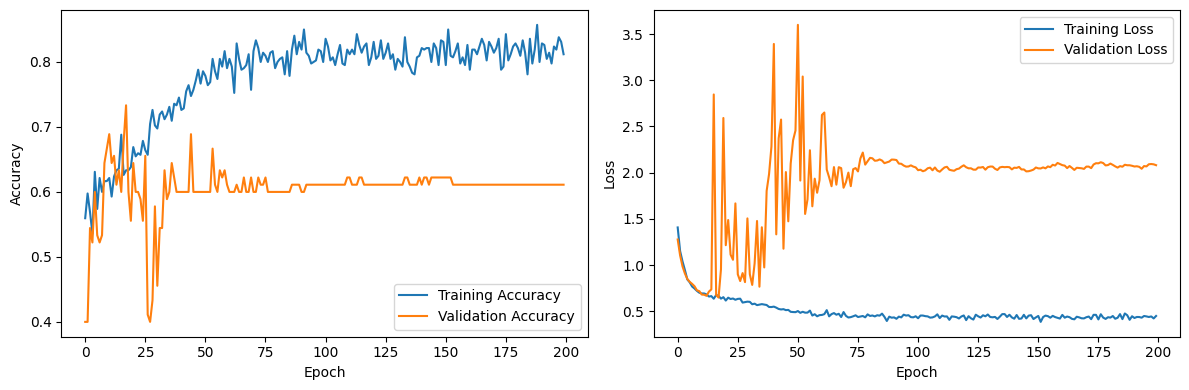

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 167, 7500, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 167, 7500, │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 167, 7500, │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 83, 3750,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 83, 3750,  │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 83, 3750,  │     18,496 │ dropout_4[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 83, 3750,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 41, 1875,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 41, 1875,  │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 41, 1875,  │     73,856 │ dropout_5[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 1875,  │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 128)    │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 1, 128)    │          0 │ reshape_1[0][0],  │
│ (Attention)         │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 1, 256)    │    263,168 │ attention_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,587,845 (6.06 MB)

 Trainable params: 529,089 (2.02 MB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 1,058,180 (4.04 MB)

In [32]:
nn_model = model_builder.build_nn_model(input_shape=X_train[0].shape)
pipeline.train_model(model_name="nn_model", model=nn_model, X_train=X_train, y_train=y_train, x_val=X_val, y_val=y_val, model_path=config.model_path, epochs=config.epochs, batch_size=config.batch_size)
nn_model.model.summary()

In [33]:
rf_model = model_builder.build_rf_model(random_state=42, n_estimators=100)
pipeline.train_model(model_name="rf_model", model=rf_model, X_train=X_train, y_train=y_train)
rf_model.save(os.path.join(config.model_path, "rf_model.joblib"))
rf_model.model

RandomForestClassifier(random_state=42)

In [34]:
knn_model = model_builder.build_knn_model(n_neighbors=3)
pipeline.train_model(model_name="knn_model", model=knn_model, X_train=X_train, y_train=y_train)
knn_model.save(os.path.join(config.model_path, "knn_model.joblib"))
knn_model.model

KNeighborsClassifier(n_neighbors=3)

In [35]:
lr_model = model_builder.build_logistic_regression_model(C=1, random_state=42, max_iter=100)
pipeline.train_model(model_name="lr_model", model=lr_model, X_train=X_train, y_train=y_train)
lr_model.save(os.path.join(config.model_path, "lr_model.joblib"))
lr_model.model

LogisticRegression(C=1, random_state=42)

In [36]:
svm_model = model_builder.build_svm_model(C=1.0, kernel="rbf")
pipeline.train_model(model_name="svm_model", model=svm_model, X_train=X_train, y_train=y_train)
svm_model.save(os.path.join(config.model_path, "svm_model.joblib"))
svm_model.model

SVC()

In [63]:
pipeline.load_model("nn_model", os.path.join(config.model_path, f"nn_model.keras"))

Loading model: nn_model from ../models/nn_model.keras
Model nn_model successfully loaded.


In [64]:
pipeline.load_model("rf_model", os.path.join(config.model_path, "rf_model.joblib"))

Loading model: rf_model from ../models/rf_model.joblib
Model rf_model successfully loaded.


In [65]:
pipeline.load_model("knn_model", os.path.join(config.model_path, "knn_model.joblib"))

Loading model: knn_model from ../models/knn_model.joblib
Model knn_model successfully loaded.


In [66]:
pipeline.load_model("lr_model", os.path.join(config.model_path, "lr_model.joblib"))

Loading model: lr_model from ../models/lr_model.joblib
Model lr_model successfully loaded.


In [67]:
pipeline.load_model("svm_model", os.path.join(config.model_path, "svm_model.joblib"))

Loading model: svm_model from ../models/svm_model.joblib
Model svm_model successfully loaded.


Enabled models for evaluation: ['nn_model']
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([26, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step
nn_model Predictions: [0.6804527  0.5483255  0.6133115  0.67754066 0.5395368  0.879574
 0.69960254 0.96892357 0.8353384  0.44560876 0.66518    0.52085274
 0.70340526 0.6858418  0.69174206 0.6805205  0.7617039  0.5911325
 0.7024243  0.7111236  0.54759806 0.62290967 0.5180585  0.5598015
 0.5911708  0.6132644  0.7450766  0.5464563  0.648316   0.65121824
 0.677707   0.7456685  0.5983151  0.6906528  0.7095363  0.53947836
 0.61848027 0.4842341  0.55453986 0.56750536 0.8795702  0.92535615
 0.8641947  0.8940051  0.8948704  0.6996476  0.78942746 0.6262156
 0.74001986 0.7295821  0.9689398  0.97480804 0.962552   0.97270525
 0.97539675 0.83530515 0.906568   0.8088635  0.86352175 0.8586575
 0.44277948 0.5340699  0.4017104  0.4780663  0.4749311  0.66302407
 0.8145862  0.6431795  0.7581867  0.687454   0.5155281  0.5869432
 0.45807347 0.4946365  0.54804695 0.7024413  0.83696747 0.67124885
 0.7844397  0.7262866  0.6843252  0.8203863  0.65437734 0.76367676
 0.70955

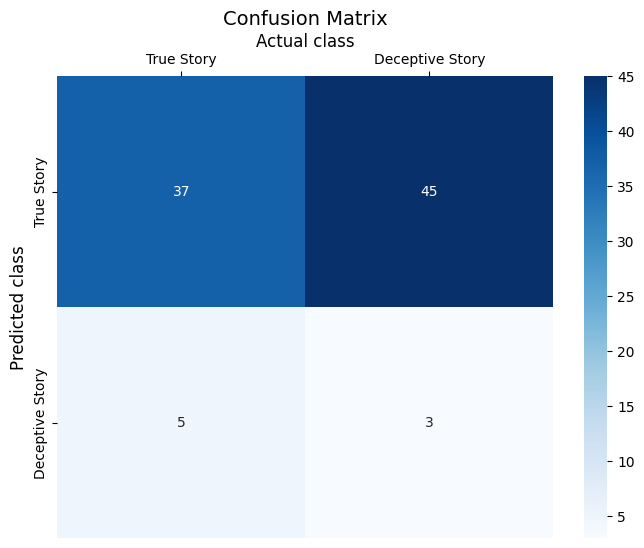

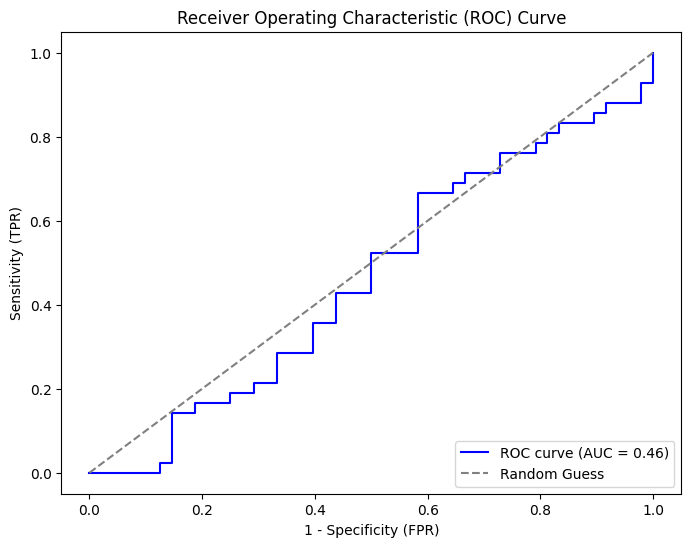


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,True Story,0.680453
1,True Story,True Story,0.548325
2,Deceptive Story,True Story,0.613312
3,True Story,True Story,0.677541
4,Deceptive Story,True Story,0.539537
...,...,...,...
85,True Story,True Story,0.689049
86,True Story,True Story,0.752723
87,True Story,True Story,0.678293
88,True Story,True Story,0.719206


In [42]:
pipeline.evaluate(X_test, y_test, test_models=["nn_model"])

Enabled models for evaluation: ['rf_model']
rf_model Predictions: [0.41 0.48 0.43 0.38 0.48 0.81 0.52 0.58 0.65 0.32 0.5  0.37 0.5  0.56
 0.5  0.41 0.54 0.31 0.59 0.42 0.48 0.41 0.45 0.52 0.53 0.43 0.6  0.34
 0.43 0.44 0.38 0.56 0.35 0.59 0.42 0.48 0.51 0.49 0.5  0.51 0.81 0.89
 0.81 0.82 0.8  0.52 0.64 0.46 0.61 0.57 0.58 0.68 0.63 0.57 0.59 0.65
 0.74 0.61 0.62 0.67 0.32 0.46 0.32 0.42 0.33 0.5  0.75 0.5  0.68 0.52
 0.37 0.38 0.41 0.45 0.42 0.51 0.67 0.58 0.7  0.53 0.56 0.73 0.47 0.76
 0.56 0.5  0.47 0.41 0.51 0.5 ]

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.44      0.46        48
           1       0.41      0.45      0.43        42

    accuracy                           0.44        90
   macro avg       0.45      0.44      0.44        90
weighted avg       0.45      0.44      0.44        90

Confusion Matrix:
 [[21 27]
 [23 19]]
Sensitivity: 0.45
Specificity: 0.44
Precision: 0.41
F1 Scor

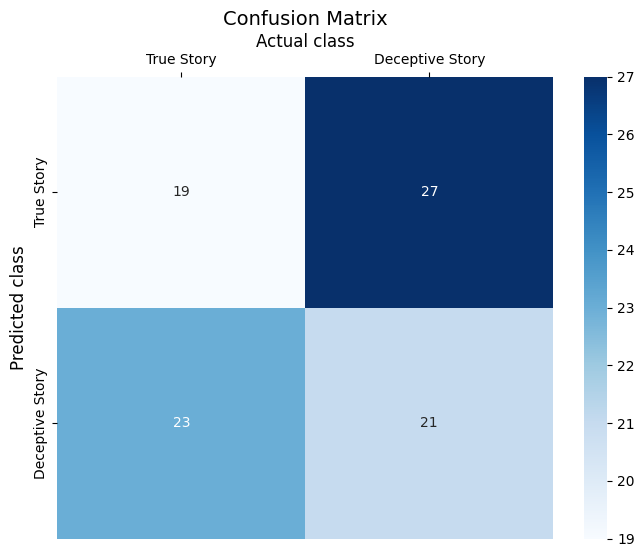

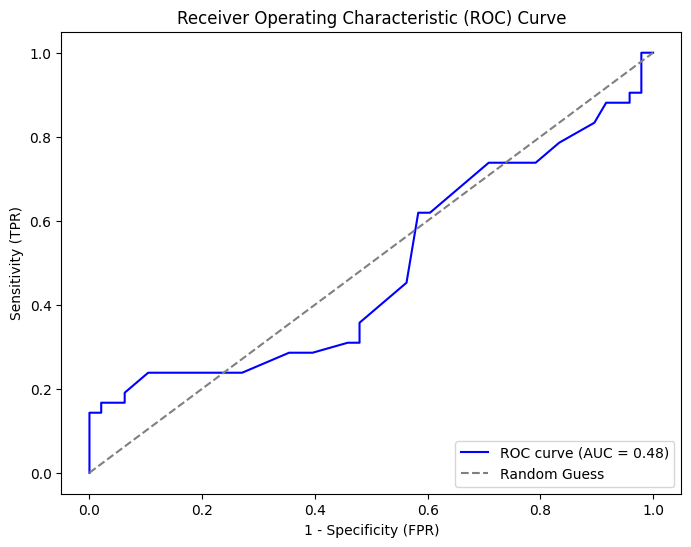


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,Deceptive Story,0.41
1,True Story,Deceptive Story,0.48
2,Deceptive Story,Deceptive Story,0.43
3,True Story,Deceptive Story,0.38
4,Deceptive Story,Deceptive Story,0.48
...,...,...,...
85,True Story,Deceptive Story,0.50
86,True Story,Deceptive Story,0.47
87,True Story,Deceptive Story,0.41
88,True Story,True Story,0.51


In [43]:
pipeline.evaluate(X_test, y_test, test_models=["rf_model"])

Enabled models for evaluation: ['knn_model']
knn_model Predictions: [1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0
 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0
 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1]

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.40      0.42        48
           1       0.40      0.45      0.42        42

    accuracy                           0.42        90
   macro avg       0.42      0.42      0.42        90
weighted avg       0.43      0.42      0.42        90

Confusion Matrix:
 [[19 29]
 [23 19]]
Sensitivity: 0.45
Specificity: 0.40
Precision: 0.40
F1 Score: 0.42
Accuracy: 0.42


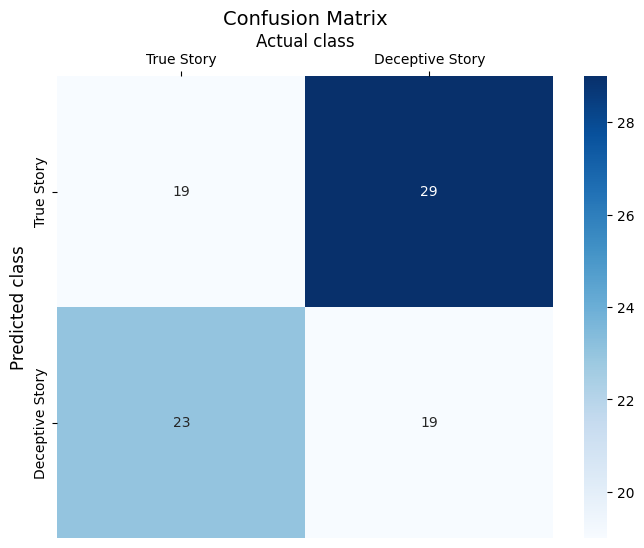

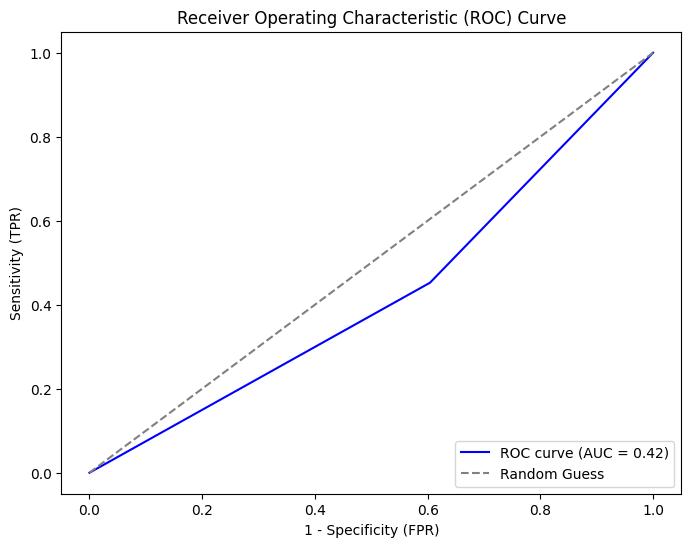


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,True Story,1.0
1,True Story,True Story,1.0
2,Deceptive Story,Deceptive Story,0.0
3,True Story,True Story,1.0
4,Deceptive Story,Deceptive Story,0.0
...,...,...,...
85,True Story,True Story,1.0
86,True Story,Deceptive Story,0.0
87,True Story,True Story,1.0
88,True Story,Deceptive Story,0.0


In [44]:
pipeline.evaluate(X_test, y_test, test_models=["knn_model"])

Enabled models for evaluation: ['lr_model']
lr_model Predictions: [9.98512240e-01 2.85123432e-02 9.99985774e-01 9.99850382e-01
 9.99200634e-01 9.99997483e-01 9.99910997e-01 4.80800932e-01
 2.74238228e-09 9.73970384e-01 7.58674008e-09 4.81582879e-07
 1.00000000e+00 1.58650789e-07 9.99977187e-01 9.98478941e-01
 9.97833160e-01 9.78775995e-01 3.12949838e-15 9.99044832e-01
 2.64780326e-02 9.71236833e-01 1.23166497e-04 9.99999997e-01
 4.01977924e-02 9.99985870e-01 3.88691964e-06 9.99964582e-01
 9.32113417e-01 9.99990578e-01 9.99850456e-01 9.99999999e-01
 9.99197920e-01 9.99996926e-01 9.99902991e-01 9.99187950e-01
 4.81478886e-08 4.25012635e-01 9.98703011e-01 9.99518992e-01
 9.99997491e-01 9.98022287e-01 9.99997937e-01 9.99999993e-01
 9.99998333e-01 9.99912059e-01 9.99972998e-01 9.99998177e-01
 9.99999459e-01 9.99942530e-01 4.77702259e-01 9.99847543e-01
 9.83700137e-01 2.89335274e-02 5.77131791e-01 2.85706607e-09
 9.99910729e-01 2.49178426e-09 2.20247447e-08 1.06684167e-08
 9.91220903e-01 1.0

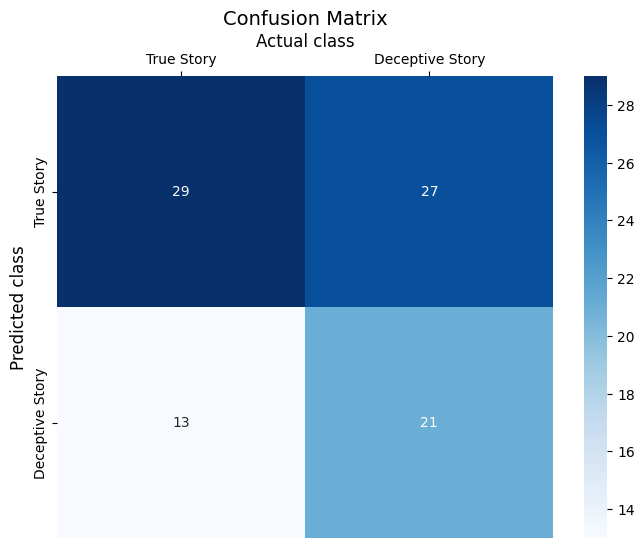

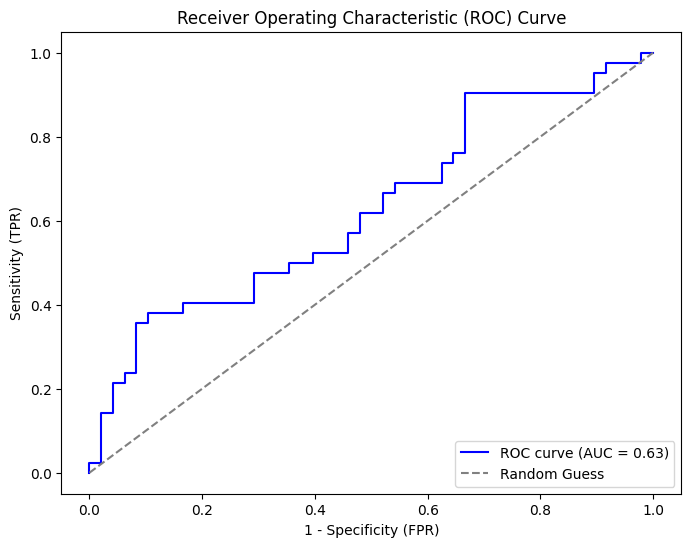


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,True Story,0.998512
1,True Story,Deceptive Story,0.028512
2,Deceptive Story,True Story,0.999986
3,True Story,True Story,0.999850
4,Deceptive Story,True Story,0.999201
...,...,...,...
85,True Story,True Story,0.999995
86,True Story,True Story,0.998452
87,True Story,Deceptive Story,0.089232
88,True Story,Deceptive Story,0.166907


In [45]:
pipeline.evaluate(X_test, y_test, test_models=["lr_model"])

Enabled models for evaluation: ['svm_model']
svm_model Predictions: [1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0
 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1]

Ensemble Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.42      0.56        48
           1       0.58      0.93      0.72        42

    accuracy                           0.66        90
   macro avg       0.73      0.67      0.64        90
weighted avg       0.74      0.66      0.63        90

Confusion Matrix:
 [[20 28]
 [ 3 39]]
Sensitivity: 0.93
Specificity: 0.42
Precision: 0.58
F1 Score: 0.72
Accuracy: 0.66


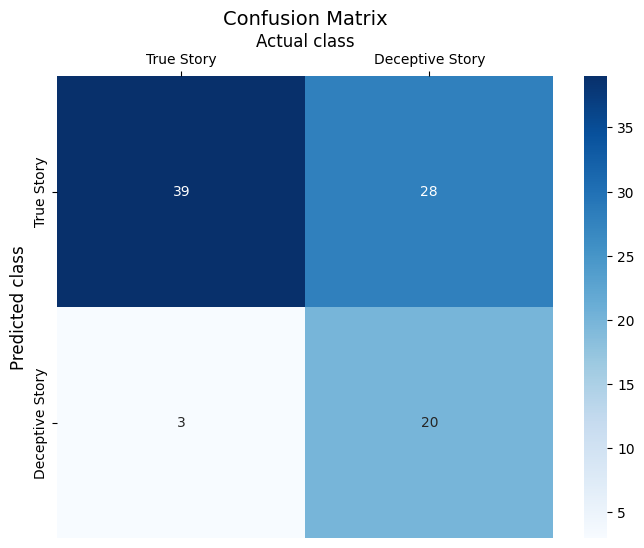

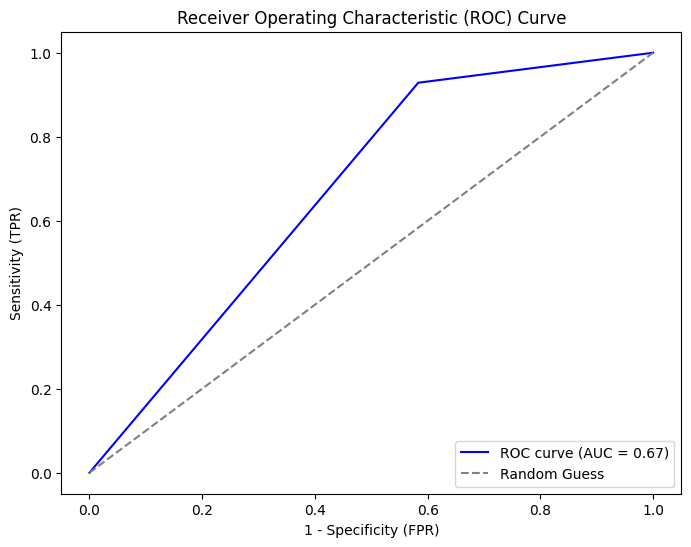


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,True Story,1.0
1,True Story,True Story,1.0
2,Deceptive Story,Deceptive Story,0.0
3,True Story,True Story,1.0
4,Deceptive Story,True Story,1.0
...,...,...,...
85,True Story,True Story,1.0
86,True Story,Deceptive Story,0.0
87,True Story,True Story,1.0
88,True Story,True Story,1.0


In [46]:
pipeline.evaluate(X_test, y_test, test_models=["svm_model"])

Enabled models for evaluation: ['nn_model', 'rf_model', 'knn_model', 'lr_model', 'svm_model']
1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([32, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step

/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([26, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
nn_model Predictions: [0.6804527  0.5483255  0.6133115  0.67754066 0.5395368  0.879574
 0.69960254 0.96892357 0.8353384  0.44560876 0.66518    0.52085274
 0.70340526 0.6858418  0.69174206 0.6805205  0.7617039  0.5911325
 0.7024243  0.7111236  0.54759806 0.62290967 0.5180585  0.5598015
 0.5911708  0.6132644  0.7450766  0.5464563  0.648316   0.65121824
 0.677707   0.7456685  0.5983151  0.6906528  0.7095363  0.53947836
 0.61848027 0.4842341  0.55453986 0.56750536 0.8795702  0.92535615
 0.8641947  0.8940051  0.8948704  0.6996476  0.78942746 0.6262156
 0.74001986 0.7295821  0.9689398  0.97480804 0.962552   0.97270525
 0.97539675 0.83530515 0.906568   0.8088635  0.86352175 0.8586575
 0.44277948 0.5340699  0.4017104  0.4780663  0.4749311  0.66302407
 0.8145862  0.6431795  0.7581867  0.687454   0.5155281  0.5869432
 0.45807347 0.4946365  0.54804695 0.7024413  0.83696747 0.67124885
 0.7844397  0.7262866  0.6843252  0.8203863  0.65437734 0.76367676
 0.70955

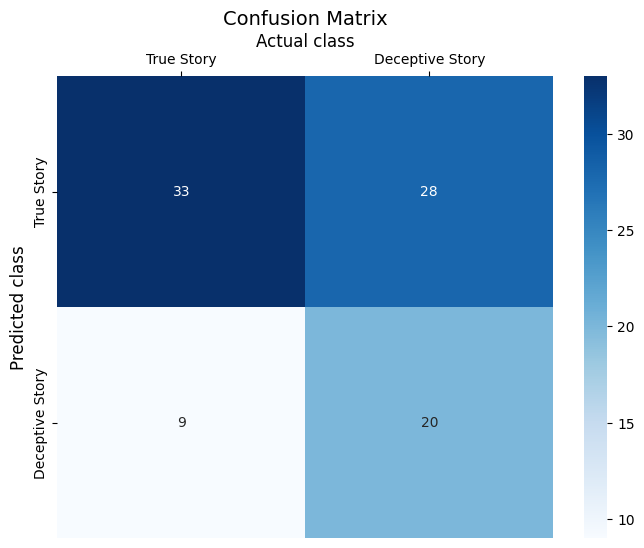

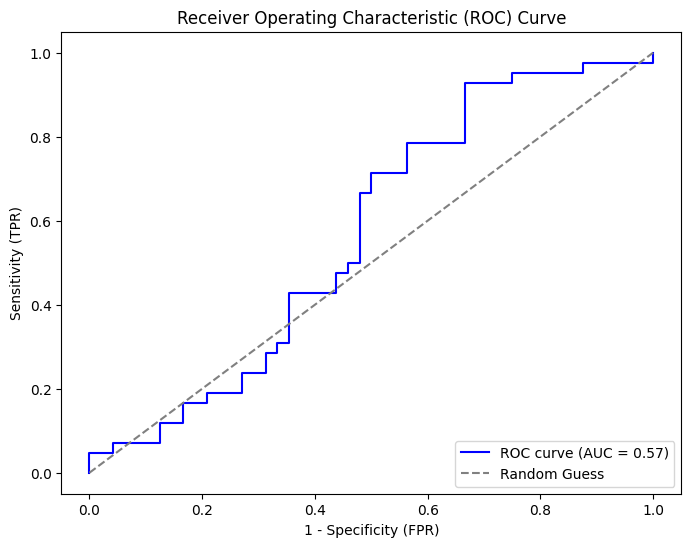


Ensemble Model Evaluation Results:


,True Labels,Predicted Labels,Predicted Probabilities
0,Deceptive Story,True Story,0.817793
1,True Story,True Story,0.611368
2,Deceptive Story,Deceptive Story,0.408659
3,True Story,True Story,0.811478
4,Deceptive Story,True Story,0.603747
...,...,...,...
85,True Story,True Story,0.837809
86,True Story,Deceptive Story,0.444235
87,True Story,True Story,0.635505
88,True Story,Deceptive Story,0.479223


In [47]:
pipeline.evaluate(X_test, y_test, test_models=["nn_model", "rf_model", "knn_model", "lr_model", "svm_model"])

In [72]:
pipeline.predict_audio("../datasets/CBU0521DD_stories/00001.wav", language="Chinese", use_models=["nn_model", "rf_model", "knn_model", "lr_model", "svm_model"])
pipeline.predict_audio("../datasets/CBU0521DD_stories/00017.wav", language="English", use_models=["nn_model", "rf_model", "knn_model", "lr_model", "svm_model"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([1, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


nn_model Predictions: [0.4602048]
rf_model Predictions: [0.96]
knn_model Predictions: [1]
lr_model Predictions: [1.]
svm_model Predictions: [1]
Predicted label: True Story
Predicted probabilities: [0.88404096]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/root/miniconda3/envs/Truora/lib/python3.10/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape torch.Size([1, 1, 1]). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


nn_model Predictions: [0.68917805]
rf_model Predictions: [0.95]
knn_model Predictions: [1]
lr_model Predictions: [1.]
svm_model Predictions: [1]
Predicted label: True Story
Predicted probabilities: [0.92783561]


np.str_('True Story')

# 7 Conclusions

Your conclusions, suggestions for improvements, etc should go here.

# 8 References

Acknowledge others here (books, papers, repositories, libraries, tools) 